In [12]:
from collections import OrderedDict
import numpy as np
import matplotlib as mpl
from matplotlib import cm
import matplotlib.pyplot as plt
import lmfit as lm
import flu_routines_new as flu
from time import time
import os
%load_ext autoreload

work_dir = "/Users/zhuzi/Documents/work/data/201912Dec/"
par_file = "sh_sample10_807_0.5MCitric_0.1mMDTPA_ph3_q0.015_par.txt"

####
qz_list = [0.006,0.015]
sh_data = []
sh_files = [ #"sh_sample9_765_0.5MCitrate_0.1mMDTPA_pH3_s1h0.2_abs8_qz0.006_flu.txt",
         "sh_sample10_806_0.5MCitric_0.1mMDTPA_ph3_q0.006_flu.txt",
         "sh_sample10_807_0.5MCitric_0.1mMDTPA_ph3_q0.015_flu.txt"
         ]
for i,q in enumerate(qz_list):
    d = np.loadtxt(os.path.join(work_dir,sh_files[i]))
    qz = np.ones(len(d)).reshape(-1,1)*qz_list[i]
    sh_data.append(np.hstack((d,qz))[:,[3,0,1,2]])
v_sh = np.vstack(tuple(sh_data))
####
q_data = []   
q_files = [#"q_sample09_760_0.5MCitric_0.1mMDTPA_ph3_flu.txt",
           #"q_sample09_761_0.5MCitric_0.1mMDTPA_ph3_flu.txt",
           #"q_sample09_767_0.5MCitric_0.1mMDTPA_ph3_flu.txt",
           "q_sample10_804_0.5MCitric_0.1mMDTPA_ph3_flu.txt"
          ]
for i,f in enumerate(q_files):
    d = np.loadtxt(os.path.join(work_dir,q_files[i]))
    sh = np.zeros(len(d)).reshape(-1,1)
    q_data.append(np.hstack((d,sh))[:,[0,3,1,2]])
v_qz = np.vstack(tuple(q_data))

v = np.vstack((v_sh, v_qz))


In [37]:
p = OrderedDict()
sys_par = OrderedDict(
            [('E_inc',      20.0),
             ('E_emt',      5.842),
             ('mu_top_inc', 0.273),
             ('mu_top_emt', 7.451),
             ('mu_bot_inc', 0.7018),
             ('mu_bot_emt', 26.58),
             ('rho_top',    0.2591),
             ('rho_bot',    0.333),
             ('width',      0.015),
             ('det_len',    12.7),
             ('beam',       'Gaussian'),
             ('span',       75.6)]
          )   
flu_par = lm.Parameters()
# add with tuples: (NAME VALUE VARY MIN  MAX  EXPR  BRUTE_STEP)
flu_par.add_many(
            ('losc', 6.2e-10 ,  False, None, None, None, None),
            ('hisc', 6.2e-10,  False, None, None, None, None),
            ('lobk', 0.0,    False, None, None, None, None),
            ('upbk', 8.8e-4,   False, None, None, None, None),
            ('surd', 5e-3,   False, 0, None, None, None),
            ('bg',   0.0,  False, None, None, None, None),
            ('qoff', 0.0e-3,   False, -1e-3, 1e-3, None, None),
            ('curv', 200,     False, None, None, None, None),
            ('loff', 0.0,    False, None, None, None, None),
            ('soff', -0.0e-3,    False, None, None, None, None)
        )   
flu_elements = [['Eu', 1, 0.947]]
p = flu.update_flu_parameters(p, flu_par, sys_par, flu_elements)

In [3]:
with open(work_dir+par_file) as fid:
    fdata=fid.readlines()
line_num = 0 
line_type = 0 # 0: not a parameter line; 1: fitting parameter line; 2: system parameter line
while True:
    try:
        line = fdata[line_num].split()
    except IndexError: # end of file
        break
    if line == []: 
        line_type = 0 
    else:
        if line[0] == 'Fitting_Parameters':
            line_type = 1 
        elif line[0] == 'Beam_Profile':
            sys_par['beam'] = line[1]
            line_type = 2 
        elif line_type == 1:
            flu_par[line[0]].value = float(line[1])
        elif line_type == 2:
            sys_par[line[0]] = float(line[1])
    line_num += 1
p = flu.update_flu_parameters(p, flu_par, sys_par, flu_elements)

> /Users/zhuzi/Documents/work/XFNTR/xfntr/flu_routines_new.py(296)fluCalFun_core()
-> flu = np.array([p['bg']] * 6)
(Pdb) p z_s[(x_s>=-p['detR']/2)*(x_s<=p['detR']/2)][[0,-1]]
array([-981.81079102, -999.87768555])
(Pdb) plt.plot(z_s[(x_s>=-p['detR']/2)*(x_s<=p['detR']/2)][[0,-1]]);plt.show()


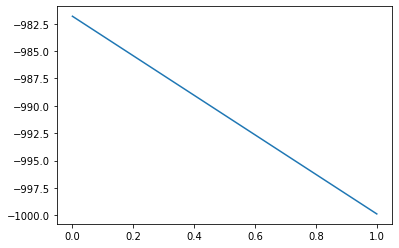

(Pdb) l
291  	    z_ref_l = -(x_ref + p['detR'] / 2) * a1  # reflection with left det. boundary: x=-l/2
292  	    z_ref_r = -(x_ref - p['detR'] / 2) * a1  # reflection with right det. boundary: x=l/2
293  	
294  	    breakpoint()
295  	    # define the initial intensity to be just background value
296  ->	    flu = np.array([p['bg']] * 6)
297  	    # two regions: region3: [-h/2a0,-l/2] & region 2: [-l/2,l/2]
298  	    x_region = [(x_s <= -p['detR'] / 2), (x_s > -p['detR'] / 2) * (x_s < p['detR'] / 2)]
299  	
300  	    ################### for redgion 1: region x>= l/2  ########################
301  	    # Special treatment for x>L/2 region.
(Pdb) p z_inc_l[[0,-1]]
array([-140961.85226928,  241203.79208969])
(Pdb) p z_inc_r[[0,-1]]
array([-241203.79790796,  140961.84645102])
(Pdb) q


BdbQuit: 

In [43]:
%aimport flu_routines_new, flu_geometry_routines
%autoreload 1

qz = np.array([0.016])
sh = np.array([0])
start = time()
flures = flu.flu2min(flu_par,(sh,qz),p)
print("{:.2f}s".format(time()-start))
# p z_s[(x_s>=-p['detR']/2)*(x_s<=p['detR']/2)][[0,-1]]

<IPython.core.display.Javascript object>


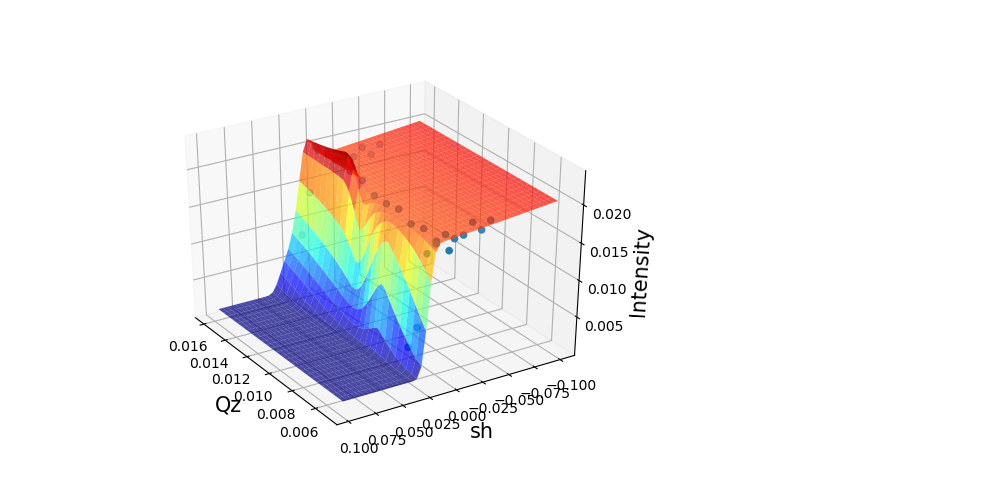

In [19]:
%matplotlib notebook
from mpl_toolkits import mplot3d

shlo,shhi = (0,-1)
fig = plt.figure(figsize=(10,5))
ax = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=2,projection='3d')
ax.set_xlabel('Qz',fontsize=15)
ax.set_ylabel('sh',fontsize=15)
ax.set_zlabel('Intensity',fontsize=15)
ax.plot_surface(flures[shlo:shhi,:,1],flures[shlo:shhi,:,0],flures[shlo:shhi,:,2],
                  cmap=cm.jet,lw=0,alpha=0.7)

vv = v[v[:,1]<=0.025]
ax.scatter(vv[:,0],vv[:,1],vv[:,2])
ax.view_init(60,30)

plt.show()

In [16]:
var_name = ['lobk','upbk','surd','qoff','soff']
flu_par['lobk'].max = 5.0e-4
flu_par['bg'].value = 0.0
flu_par['loff'].value = 0.0
flu_par['upbk'].value = 0.4e-3
flu_par['lobk'].value = 3e-3
for n in var_name: flu_par[n].vary = True

start = time()
result = lm.minimize(flu.flu2min_new,flu_par,
                         args=((vv[:,0],vv[:,1]),p),
                         kws={'data':vv[:,2],'eps':vv[:,3]}
             )
print("{:.2f}s".format(time()-start))
print(lm.fit_report(result))

28.73s
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 83
    # data points      = 32
    # variables        = 5
    chi-square         = 1323.21384
    reduced chi-square = 49.0079200
    Akaike info crit   = 129.106652
    Bayesian info crit = 136.435332
##  Warning: uncertainties could not be estimated:
    lobk:  at initial value
    lobk:  at boundary
    surd:  at boundary
[[Variables]]
    losc:  5.27e-09 (fixed)
    hisc:  5.27e-09 (fixed)
    lobk:  5.0000e-04 (init = 0.0005)
    upbk:  4.3066e-04 (init = 0.0004)
    surd:  0.00000000 (init = 0)
    bg:    0 (fixed)
    qoff: -6.0525e-04 (init = -0.000756)
    curv:  200 (fixed)
    loff:  0 (fixed)
    soff: -0.00561588 (init = -0.007)


In [17]:
qz = np.linspace(0.005,0.016,51)
sh = np.linspace(-0.1,0.1,51)
start = time()
# flu_par['hisc'].value = 5e-9
flures_fit = flu.flu2min(result.params,(sh,qz),p)
print("{:.2f}s".format(time()-start))

26.39s


<IPython.core.display.Javascript object>


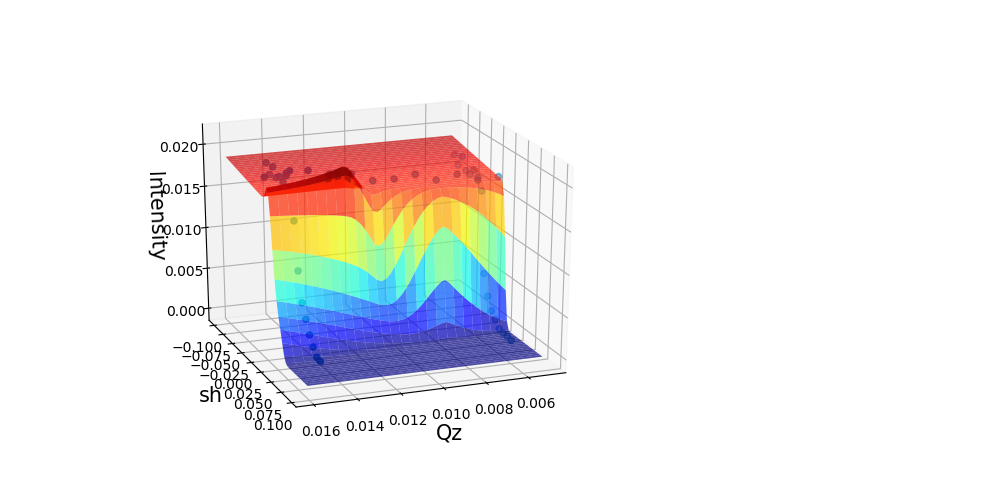

In [18]:
%matplotlib notebook
from mpl_toolkits import mplot3d

shlo,shhi = (0,-1)
fig = plt.figure(figsize=(10,5))
ax = plt.subplot2grid((1,3),(0,0),rowspan=1,colspan=2,projection='3d')
ax.set_xlabel('Qz',fontsize=15)
ax.set_ylabel('sh',fontsize=15)
ax.set_zlabel('Intensity',fontsize=15)
ax.plot_surface(flures_fit[shlo:shhi,:,1],flures_fit[shlo:shhi,:,0],flures_fit[shlo:shhi,:,2],
                  cmap=cm.jet,lw=0,alpha=0.7)

ax.scatter(v[:,0],v[:,1],v[:,2])

ax.view_init(60,30)
plt.show()